# Activity: Build an XGBoost model

## Introduction

In this activity, you’ll build on the skills and techniques you learned in the decision tree and random forest lessons to construct your own XGBoost classification model. The XGBoost model is a very powerful extension of decision trees, so having a strong working familiarity with this process will strengthen your skills and resume as a data professional.

This activity is a continuation of the airlines project in which you built decision tree and random forest models. You will use the same data, but this time you will train, tune, and evaluate an XGBoost model. You’ll then compare the performance of all three models and decide which model is best. Finally, you’ll explore the feature importances of your model and identify the features that most contribute to customer satisfaction.


## Step 1: Imports

### Import packages

Begin with your import statements. First, import `pandas`, `numpy`, and `matplotlib` for data preparation. Next, import scikit-learn (`sklearn`) for model preparation and evaluation. Then, import `xgboost`, which provides the classification algorithm you'll implement to formulate your predictive model.

In [17]:
# Import relevant libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier, plot_importance

### Load the dataset

To formulate your model, `pandas` is used to import a csv of airline passenger satisfaction data called `Invistico_Airline.csv`. This DataFrame is called `airline_data`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [2]:
airline_data = pd.read_csv('Invistico_Airline.csv', error_bad_lines=False)

### Display the data

Examine the first 10 rows of data to familiarize yourself with the dataset.

In [3]:
airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


### Display the data type for each column

Next, observe the types of data present within this dataset.

In [4]:
# Display the data type for each column in your DataFrame.
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

**Question:** Identify the target (or predicted) variable for passenger satisfaction. What is your initial hypothesis about which variables will be valuable in predicting satisfaction?

- 'satisfaction' column will be the target variable
- While many of variables can affect customer satisfaction, 'Arrival Delay in Minutes', 'Cleanliness', and 'Seat Comfort' will be more important features to affect satisfaction.

In [5]:
airline_data['satisfaction'].value_counts(normalize=True)

satisfied       0.547328
dissatisfied    0.452672
Name: satisfaction, dtype: float64

## Step 2: Model preparation

Before you proceed with modeling, consider which metrics you will ultimately want to leverage to evaluate your model.

**Question:** Which metrics are most suited to evaluating this type of model?

I would say that it is more important to find customers who are dissatisfied making 'satisfied' as 0  and 'dissatisfied' as 1. So we do not want to predict 'satisfied'(0) for the customers who are actually dissatisfied(1). We will try to minimize False Negative and Recall could be the most suited for evaluating this model.

### Prepare your data for predictions

You may have noticed when previewing your data that there are several non-numerical variables (`object` data types) within the dataset.

To prepare this DataFrame for modeling, first convert these variables into a numerical format.

In [6]:
cols_object = list()
for col in airline_data.columns:
    col_type = airline_data[col].dtype
    if col_type == object:
        cols_object.append(col)

print(f"Columns that need to be converted to numeric: {cols_object}")

Columns that need to be converted to numeric: ['satisfaction', 'Customer Type', 'Type of Travel', 'Class']


In [7]:
# Convert the object predictor variables to numerical dummies.
airline_data_dummies = pd.get_dummies(airline_data,
                                     columns = cols_object)

In [8]:
airline_data_dummies.head(1)

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,...,Arrival Delay in Minutes,satisfaction_dissatisfied,satisfaction_satisfied,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,65,265,0,0,0,2,2,4,2,3,...,0.0,0,1,1,0,0,1,0,1,0


### Isolate your target and predictor variables
Separately define the target variable (`satisfaction`) and the features.

In [9]:
# Define the y (target) variable.
y = airline_data_dummies['satisfaction_dissatisfied']
# Define the X (predictor) variables.
X = airline_data_dummies.drop(['satisfaction_satisfied', 'satisfaction_dissatisfied'], axis=1)

### Divide your data 

Divide your data into a training set (75% of the data) and test set (25% of the data). This is an important step in the process, as it allows you to reserve a part of the data that the model has not used to test how well the model generalizes (or performs) on new data.

In [10]:
# Perform the split operation on your data.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

## Step 3: Model building

### "Instantiate" your XGBClassifer

Before you fit your model to your airline dataset, first create the XGB Classifier model and define its objective. You'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [11]:
# Define xgb to be your XGBClassifier.
xgb = XGBClassifier(random_state=0)

### Define the parameters for hyperparameter tuning

To identify suitable parameters for your `xgboost` model, first define the parameters for hyperparameter tuning. Specifically, define a range of values for `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`.

Consider a more limited range for each parameter to allow for timely iteration and model training.

In [12]:
# Define parameters for tuning as `cv_params`.
cv_params = {'max_depth' : [4, 6],
             'min_child_weight': [3, 5],
             'learning_rate': [0.05, 0.1, 0.5],
             'n_estimators': [5, 10, 20],
             'subsample': [0.7],
             'colsample_bytree': [0.7]
}

**Question:** What is the likely effect of adding more estimators to your GridSearch?

Adding more estimators will improve the performance but once it is converged, it will just take more time to train over and over for the relatively small amount of improvement.

### Define how the models will be evaluated

Define how the models will be evaluated for hyperparameter tuning. To yield the best understanding of model performance, utilize a suite of metrics.

In [13]:
# Define your criteria as `scoring`.
scoring = {'accuracy', 'precision', 'recall', 'f1'}

### Construct the GridSearch cross-validation 

Construct the GridSearch cross-validation using the model, parameters, and scoring metrics you defined. Additionally, define the number of folds and specify *which metric* from above will guide the refit strategy.

In [14]:
# Construct your GridSearch.
xgb_cv = GridSearchCV(xgb,
                     cv_params,
                     scoring = scoring,
                     cv = 5,
                     refit = 'recall')

### Fit the GridSearch model to your training data

If your GridSearch takes too long, revisit the parameter ranges above and consider narrowing the range and reducing the number of estimators.

In [15]:
%%time
# fit the GridSearch model to training data
xgb_cv = xgb_cv.fit(X_train, y_train)

CPU times: user 3min 49s, sys: 4.3 s, total: 3min 54s
Wall time: 2min 3s


In [16]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.5,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 20,
 'subsample': 0.7}

**Question:** Which optimal set of parameters did the GridSearch yield?

[Write your response here. Double-click (or enter) to edit.]

### Save your model for reference using `pickle`

Use the `pickle` library you've already imported to save the output of this model.

In [18]:
# Use `pickle` to save the trained model.
pickle.dump(xgb_cv, open('xgb_cv.sav', 'wb'))

### Use your fitted model to create predictions for your test set

First, define `nb` to be the relevant algorithm from `sklearn`.`naive_bayes`. Then, fit your model to your training data. You will use this fitted model to create predictions for your test data.

## Step 4: Results and evaluation

### Formulate predictions on your test set

To evaluate the predictions yielded from your model, leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to your model's prediction.

First, use your trained model to formulate predictions on your test set.

In [19]:
# Apply your model to predict on your test data. Call this output "y_pred".
y_pred = xgb_cv.predict(X_test)

### Leverage metrics to evaluate your model's performance

Apply a series of metrics from scikit-learn to assess your model. Specifically, print the accuracy score, precision score, recall score, and f1 score associated with your test data and predicted values.

In [20]:
# 1. Print your accuracy score.
acc_score = metrics.accuracy_score(y_test, y_pred)

# 2. Print your precision score.
precision_score = metrics.precision_score(y_test, y_pred)

# 3. Print your recall score.
recall_score = metrics.recall_score(y_test, y_pred)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_pred)

print(f"Accuracy : {acc_score}")
print(f"Precision: {precision_score}")
print(f"Recall   : {recall_score}")
print(f"f1.      : {f1_score}")

Accuracy : 0.9454573452417616
Precision: 0.9315510176664203
Recall   : 0.948563611491108
f1.      : 0.9399803436472701


**Question:** How should you interpret your accuracy score?

Accuracy score is 0.945 meaning that 94.5% accurate in overall.

**Question:** Is your accuracy score alone sufficient to evaluate your model?

We have to look at other Precision and Recall how the model handles False Positives and False Negatives.

**Question:** When observing the precision and recall scores of your model, how do you interpret these values, and is one more accurate than the other?

Higher recall value indicates that the model performs well to predict True Positive with less False Negatives than False Positives.

**Question:** What does your model's F1 score tell you, beyond what the other metrics provide?*

F1 score balances precision an recall showing that the model shows very strong predictive power with 94% f1 score.

### Gain clarity with the confusion matrix

Recall that a **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives. It helps to create a visual representation of the components feeding into the metrics above.

Create a confusion matrix based on your predicted values for the test set.

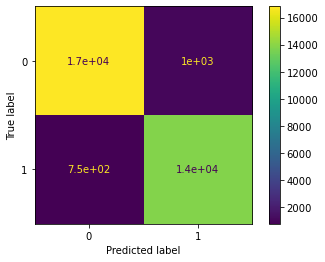

In [22]:
# Construct and display your confusion matrix.
# Construct the confusion matrix for your predicted and test values.
cm = metrics.confusion_matrix(y_test, y_pred)
# Create the display for your confusion matrix.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                     display_labels = xgb_cv.classes_)

# Plot the visual in-line.
disp.plot()
plt.show()

**Question:** When observing your confusion matrix, what do you notice? Does this correlate to any of your other calculations?

As recall and precision score indicated, the False Negatives is less than False Positives saying that the model is good at predicting dissatisfied customers correctly.

### Visualize most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. Output and examine the feature importance of your model.

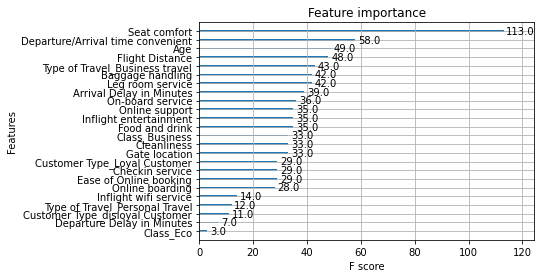

In [23]:
# Plot the relative feature importance of the predictor variables in your model.
plot_importance(xgb_cv.best_estimator_)

**Question:** Examine the feature importances outputted above. What is your assessment of the result? Did anything surprise you?

The feature importances show that 'Seat comfort' had the greatest impact, then Departure/Arrival time convinent.
I am surprised that 'Age' affects the the satisfaction level as well and it is good indicator that it is better to provide different services by ages.

### Compare models

Create a table of results to compare model performance.

In [26]:
# Create a table of results to compare model performance.

table = pd.DataFrame()
table = table.append({'Model': "Tuned Decision Tree",
                        'F1':  0.945214,
                        'Recall': 0.935487,
                        'Precision': 0.955169,
                        'Accuracy': 0.940648
                      },
                        ignore_index=True
                    )

table = table.append({'Model': "Tuned Random Forest",
                        'F1':  0.947306,
                        'Recall': 0.944501,
                        'Precision': 0.950128,
                        'Accuracy': 0.942450
                      },
                        ignore_index=True
                    )

table = table.append({'Model': "Tuned XGBoost",
                        'F1':  f1_score,
                        'Recall': recall_score,
                        'Precision': precision_score,
                        'Accuracy': acc_score
                      },
                        ignore_index=True
                    )

table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.945214,0.935487,0.955169,0.940648
1,Tuned Random Forest,0.947306,0.944501,0.950128,0.942450
2,Tuned XGBoost,0.939980,0.948564,0.931551,0.945457


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Create a DataFrame and use the `append()` function to add the results of each model as a new row.

</details>

**Question:** How does this model compare to the decision tree and random forest models you built in previous labs? 

XGBoost performed well in recall while Decision Tree and Radom Forest performe well in F1 score and precision.